# Simple Linear Regression
Haytham Mohamed

INFS 890 - Spring 2020

In [790]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [791]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True

test_split = 0.1

In [792]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [793]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.0700,0.0200,0.0100,0.0200,0.0200,0.0100,0.0100,0.1200,0.1600,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.1800,0.4000,0.4000
1,0.0600,0.0300,0.0100,0.0200,0.0200,0.0100,0.0100,0.1400,0.1700,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.1800,0.4400,0.3900
2,0.2100,0.0600,0.0200,0.0500,0.0300,0.0200,0.0100,0.2400,0.6600,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.8400,1.5800,0.4200
3,0.2200,0.0600,0.0200,0.0600,0.0400,0.0200,0.0100,0.2100,0.6600,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.8300,1.5800,0.4100
4,0.2100,0.0600,0.0100,0.0500,0.0400,0.0200,0.0100,0.1500,0.6600,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.7500,1.4900,0.3900


In [794]:
data.shape

(3175, 18)

In [795]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 17 features


In [796]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

In [797]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

if 1 == 0:
    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


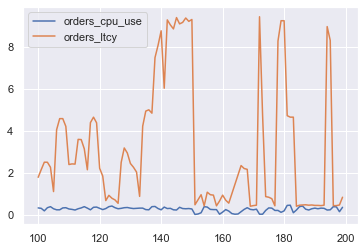

In [798]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [799]:
#lasso = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
#sfm1 = SelectFromModel(lasso, threshold='0.01*mean')

rfr = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
sfm = SelectFromModel(rfr, threshold='0.01*mean')

#sfm = SelectKBest(k=6)

#sfm = PCA(random_state=180)

reg = LinearRegression(normalize=True) # normalize false bacause we are going to use the scaler

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', sfm),
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    'selector__threshold': ['1*mean', '0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean', '0.001*mean'] # with tree
    , 'selector__estimator__max_depth' : [10, 15]
    , 'selector__estimator__n_estimators' : [20, 30, 40]
    # 'selector__n_components' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]   # with PCA
    , 'reg__normalize': [False, True]
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [800]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

search.fit(x_train, y_train)

sklearn version 0.22.2.post1
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.2min finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                      

# Best Model

In [801]:
score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

#print("")
#all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

#print('mean train scores')
#print(all_training_scores['mean_train_score'])

#print('mean test scores')
#print(all_training_scores['mean_test_score'])


Best CV test score = -0.0685:
Best CV params = {'reg__normalize': False, 'selector__estimator__max_depth': 15, 'selector__estimator__n_estimators': 40, 'selector__threshold': '0.05*mean'}


# Features Selected

In [802]:
if 1 == 0:
    best_threshold = params['selector__threshold']
    best_max_depth = params['selector__estimator__max_depth']
    best_n_estimators = params['selector__estimator__n_estimators']

    select_model = RandomForestRegressor(n_jobs=-1, max_depth=best_max_depth, n_estimators=best_n_estimators)
    sfm = SelectFromModel(model, threshold=best_threshold)

    selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train[feature_list]
    #reduced_x_train.head(2)
    print('')
    for feature in reduced_x_train.columns.values:
        print(feature)

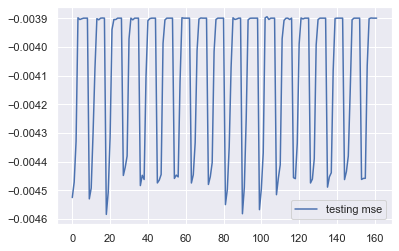

In [803]:
pdf = pd.DataFrame(all_training_scores['mean_test_score'], columns=['testing mse'])
pdf.plot()

# Training R2

In [804]:
y_train_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_hat)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = 0.426907799129582
Score (training) = -0.06786313646188935


In [805]:
estimator = search.best_estimator_

estimator.named_steps.reg.intercept_

array([0.47027753])

In [806]:
estimator.named_steps.reg.coef_

array([[-0.17417778, -0.07460606, -0.07814546,  0.36042079, -0.04970021,
        -0.03973335,  0.30314374,  0.06193797,  0.64300282, -0.40968248,
        -0.05983041, -0.07102594]])

In [807]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.22 (0.14) 0.00 1.00 MSE


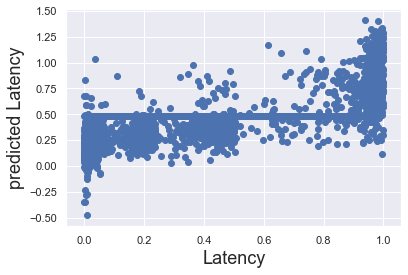

In [808]:
plt.scatter(y_train, y_train_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

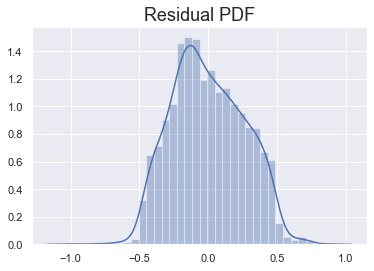

In [809]:
sns.distplot(y_train - y_train_hat)
plt.title('Residual PDF', size=18)

# Testing

In [810]:
y_test_hat = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

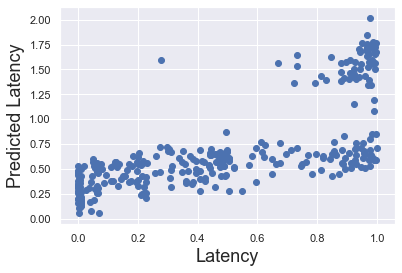

In [811]:
plt.scatter(y_test, y_test_hat)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

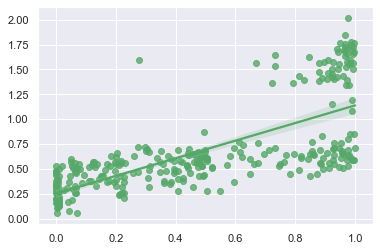

In [812]:
ax = sns.regplot(x=y_test, y=y_test_hat, color='g')

In [813]:
perf = pd.DataFrame(y_test_hat, columns=['prediction'])
perf['target'] = y_test
perf.head()

,prediction,target
0,0.1578,0.0016
1,0.1304,0.0071
2,0.1362,0.0093
3,0.1522,0.0027
4,0.2801,0.0016


In [814]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,0.1578,0.0016,0.1562,"9,896.4767"
1,0.1304,0.0071,0.1234,"1,743.2056"
2,0.1362,0.0093,0.1269,"1,368.1663"
3,0.1522,0.0027,0.1496,"5,584.5913"
4,0.2801,0.0016,0.2785,"17,646.3164"
...,...,...,...,...
313,1.5066,0.9945,0.5121,51.4913
314,1.6720,0.9967,0.6753,67.7499
315,1.7290,0.9945,0.7345,73.8605
316,1.4258,0.9384,0.4873,51.9328


In [815]:
perf.describe()

,prediction,target,residual,difference%
count,318.0000,318.0000,318.0000,318.0000
mean,0.6791,0.4823,0.1968,"2,326.2932"
std,0.4480,0.3622,0.3151,"9,852.1263"
min,0.0555,0.0005,-0.4536,0.5016
25%,0.4034,0.1302,-0.0004,27.6186
50%,0.5595,0.4585,0.1906,60.1177
75%,0.6925,0.8859,0.4056,231.8584
max,2.0154,1.0000,1.3178,"96,126.9063"


In [816]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
189,0.52,0.52,-0.00,0.50
258,0.62,0.62,-0.01,0.84
224,0.40,0.41,-0.01,1.57
100,0.51,0.52,-0.01,2.04
99,0.32,0.31,0.01,2.06
248,0.35,0.36,-0.01,2.52
190,0.69,0.71,-0.02,2.65
213,0.46,0.45,0.01,3.25
175,0.71,0.73,-0.03,3.42
128,0.37,0.36,0.01,3.54


# *** Prediction Accuracy

In [817]:
r2_test = metrics.r2_score(y_test, y_test_hat)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = -0.05299274291261358


In [818]:
print(np.sqrt(mean_squared_error(y_test,y_test_hat)))

0.3711171707688548
